In [5]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
    

In [7]:
img_path = "DIAT-uSAT_dataset"

In [8]:
walk_through_dir(img_path)

There are 6 directories and 1 images in DIAT-uSAT_dataset
There are 0 directories and 400 images in DIAT-uSAT_dataset/3_short_blade_rotor
There are 0 directories and 415 images in DIAT-uSAT_dataset/Bird+mini-helicopter
There are 0 directories and 835 images in DIAT-uSAT_dataset/drone
There are 0 directories and 800 images in DIAT-uSAT_dataset/rc_plane
There are 0 directories and 800 images in DIAT-uSAT_dataset/Bird
There are 0 directories and 799 images in DIAT-uSAT_dataset/3_long_blade_rotor


In [9]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, subfolders, transform=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder

            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define the base directory and subfolders
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [10]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform)

In [11]:
len(dataset)

4049

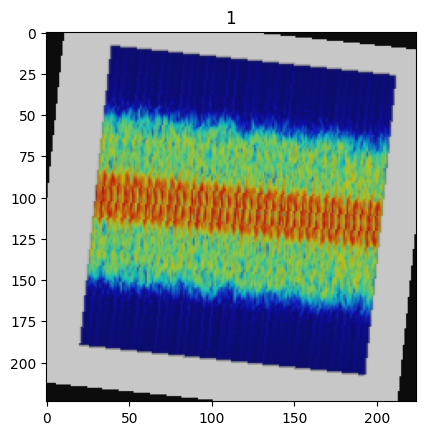

In [12]:
image ,label = dataset.__getitem__(800)
plt.title(label)
plt.imshow(image.squeeze().permute(1,2,0));

In [13]:
# Encoding labels into numerical values and converting to categorical format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(dataset.labels)
num_classes = len(label_encoder.classes_)

In [14]:
len(encoded_labels)

4049

In [15]:
num_classes

6

In [16]:
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [17]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3441, 202, 406)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
device = "mps"

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, 6)  # Output for 6 classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [95]:
# Initialize Deeper CNN model
model_deepercnn = CustomCNN(num_classes=6)
model_deepercnn.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [96]:
optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scheduler_deepercnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_deepercnn, mode='min', factor=0.5, patience=2, min_lr=1e-7, verbose=True)

In [27]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [24]:
import torch
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, device=None):
    train_time_start = timer()
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model.to(device)
    best_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.float() / len(train_loader.dataset)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        
        with torch.inference_mode():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * images.size(0)
                val_corrects += torch.sum(preds == labels.data)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.float() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        if val_acc > best_acc:
            best_acc = val_acc
            # You might want to save the best model here
            # torch.save(model.state_dict(), 'best_model.pth')
    train_time_end = timer()
    return model, best_acc

In [100]:
model, best_acc = train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn)
print(f"Total Time Taken: {train_time_start - train_time_end}")

Using device: mps


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss: 1.4491, Accuracy: 0.5243
Validation Loss: 1.0855, Accuracy: 0.6584
Epoch [2/25], Loss: 0.9491, Accuracy: 0.6943
Validation Loss: 0.7765, Accuracy: 0.7178
Epoch [3/25], Loss: 0.7154, Accuracy: 0.7594
Validation Loss: 0.6273, Accuracy: 0.7970
Epoch [4/25], Loss: 0.5971, Accuracy: 0.8003
Validation Loss: 0.4847, Accuracy: 0.8812
Epoch [5/25], Loss: 0.5080, Accuracy: 0.8285
Validation Loss: 0.4719, Accuracy: 0.8416
Epoch [6/25], Loss: 0.4507, Accuracy: 0.8518
Validation Loss: 0.3591, Accuracy: 0.9158
Epoch [7/25], Loss: 0.4205, Accuracy: 0.8550
Validation Loss: 0.3595, Accuracy: 0.8960
Epoch [8/25], Loss: 0.3776, Accuracy: 0.8750
Validation Loss: 0.4778, Accuracy: 0.8366
Epoch [9/25], Loss: 0.3630, Accuracy: 0.8771
Validation Loss: 0.3881, Accuracy: 0.8762
Epoch [10/25], Loss: 0.3331, Accuracy: 0.8899
Validation Loss: 0.2531, Accuracy: 0.9307
Epoch [11/25], Loss: 0.3216, Accuracy: 0.8913
Validation Loss: 0.2605, Accuracy: 0.9455
Epoch [12/25], Loss: 0.3082, Accuracy: 0.

NameError: name 'train_time_start' is not defined

In [25]:
# Test function
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            test_loss += loss.item() * images.size(0)
            test_corrects += torch.sum(preds == labels.data)
    
    test_loss /= len(test_loader.dataset)
    test_acc = test_corrects.float().cpu()/ len(test_loader.dataset)
    
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

In [104]:
test_model(model_deepercnn, test_loader, criterion)

  0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.1261, Accuracy: 0.9581


In [105]:
torch.save(model_deepercnn.state_dict(), "deeper_cnn.pth")

# TINY VGG (CNN Exaplainer type):

In [20]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, in_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.in_channels = in_channels
        self.output_shape = output_shape
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the output size of convolutional blocks
        conv_output_size = self._get_conv_output_size(224)  # Input size is 224x224
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=conv_output_size, out_features=output_shape)
        )
    
    def _get_conv_output_size(self, input_size):
        # Helper method to calculate the output size of the convolutional blocks
        x = torch.randn(1, self.in_channels, input_size, input_size)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x.numel() // x.size(0)  # Total number of elements divided by batch size
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

# Create the model instance
model_tinyvgg = TinyVGG(in_channels=3, hidden_units=16, output_shape=6)  

In [21]:
import torch.optim as optim

# Define the optimizer
optimizer_tinyvgg = optim.Adam(model_tinyvgg.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler_tinyvgg = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_tinyvgg, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7, 
    verbose=True
)

/Users/aryansaini/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
model_tinyvgg

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=6, bias=True)
  )
)

In [28]:
# Train the model
model_tinyvgg, best_acc = train_model(
    model_tinyvgg, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer_tinyvgg, 
    scheduler_tinyvgg, 
    num_epochs=30,
    device=torch.device("mps")  
)

Using device: mps


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Loss: 1.0552, Accuracy: 0.5911
Validation Loss: 0.7010, Accuracy: 0.7624
Epoch [2/30], Loss: 0.6845, Accuracy: 0.7486
Validation Loss: 0.5692, Accuracy: 0.7871
Epoch [3/30], Loss: 0.6173, Accuracy: 0.7724
Validation Loss: 0.5745, Accuracy: 0.8020
Epoch [4/30], Loss: 0.5585, Accuracy: 0.8030
Validation Loss: 0.5244, Accuracy: 0.8267
Epoch [5/30], Loss: 0.4769, Accuracy: 0.8341
Validation Loss: 0.4149, Accuracy: 0.8416
Epoch [6/30], Loss: 0.4302, Accuracy: 0.8390
Validation Loss: 0.3750, Accuracy: 0.8416
Epoch [7/30], Loss: 0.3783, Accuracy: 0.8675
Validation Loss: 0.3213, Accuracy: 0.8861
Epoch [8/30], Loss: 0.3221, Accuracy: 0.8901
Validation Loss: 0.2448, Accuracy: 0.8911
Epoch [9/30], Loss: 0.2891, Accuracy: 0.9053
Validation Loss: 0.2445, Accuracy: 0.9208
Epoch [10/30], Loss: 0.2434, Accuracy: 0.9189
Validation Loss: 0.2516, Accuracy: 0.8713
Epoch [11/30], Loss: 0.2264, Accuracy: 0.9236
Validation Loss: 0.1764, Accuracy: 0.9505
Epoch [12/30], Loss: 0.1961, Accuracy: 0.

KeyboardInterrupt: 

In [29]:
test_model(model_tinyvgg, test_loader, criterion)

  0%|          | 0/13 [00:00<?, ?it/s]

Test Loss: 0.0759, Accuracy: 0.9828


In [30]:
torch.save(model_tinyvgg.state_dict(), "tinyvgg.pth")

In [31]:
class_names = subfolders = [
    r"3_long_blade_rotor", 
    r"3_short_blade_rotor", 
    r"Bird", 
    r"Bird+mini-helicopter", 
    r"drone", 
    r"rc_plane", 
]

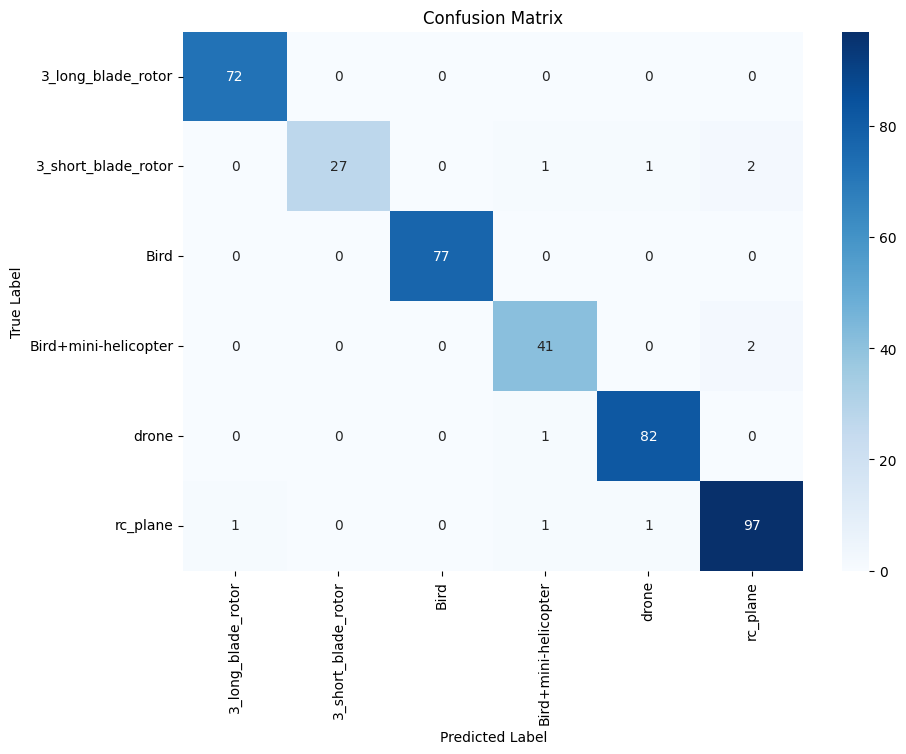

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model_tinyvgg.eval()

true_labels = []
pred_labels = []

# No gradient calculation needed
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model predictions
        outputs = model_tinyvgg(inputs)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score
        
        # Store the true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()